# <center>Домашнее задание
## Сверточные сети
Необязательное домашнее задание
1. Реализовать сверточный автокодировщик
2. Сделать оптимизацию изображения под активацию сверточных нейронов классификатора
3. Сделать оптимизацию изображения под активацию сверточных нейронов автокодировщика

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir('drive/My Drive/Colab Notebooks/neural_OTUS')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import numpy as np
import torchvision
# from torchvision import models, transforms
from torchvision import transforms
import torch.nn.functional as F
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import matplotlib
import time
import os
import copy

from utils import mnist, plot_graphs, plot_mnist, mnist_transform

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Задача

1. Обучите свою маленькую сверточную сеть с нуля на MNIST или FashionMNIST
2. Поставьте модель в eval()
3. Создайте тензор картинки, которую нужно будет оптимизировать.
4. Задайте функцию потерь.
5. Допишите функцию, которая оптимизирует картинку под вашу функцию потерь и выдаёт её.

## <center>**Пояснения к задаче и примеры**

In [ ]:
# Вот так можно создать обучаемый тензор со случайными числами и с размерностью картинки 1*28*28
image = torch.randn((1,28,28))*0.001
image = image.to(device)
image.requires_grad = True

На этом этапе у вас уже есть обученная модель с фиксированными параметрами (вы не хотите их больше обучать).

В данном примере в качестве "модели" я возьму пару линейных слоёв.

In [ ]:
model = torch.nn.Sequential(
torch.nn.Linear(in_features=1*28*28, out_features=50),
torch.nn.Tanh(),
torch.nn.Linear(in_features=50, out_features=3),
torch.nn.Softmax(dim=1)
)

In [ ]:
# так мы переводим модель в режим inference [вывод предсказаний],
# это особенно важно, если в вашей моделе есть такие слои как Dropout/Batchnorm
# потому что в процессе оптимизации картинки вы не хотите чтобы параметры сети менялись
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=3, bias=True)
  (3): Softmax(dim=1)
)

In [ ]:
# быстрая проверка что сейчас выдаёт модель на картинку
model.to(device)
image.to(device)

# вам не нужно будет делать flatten в случае сверточной модели
output = model(image.flatten().unsqueeze(0))
output

tensor([[0.3624, 0.3188, 0.3188]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
torch.argmax(output)

tensor(0, device='cuda:0')

Теперь необходимо дописать вот эту функцию, которая принимает на вход номер класса (**class_number**) (в моем примере классов всего 3 на выходе), и производит оптимизацию над картинкой так чтобы было верным условие:

``torch.argmax(model(image)) == class_number``

Для этого нужно задать условие на функцию потерь. Это уже часть вашего задания понять как это сделать.

В своем примере я покажу как оптимизировать картинку, чтобы генерируемая картинка классифицировалась как заданный класс

In [ ]:
def optimize_image_by_class(class_number, num_steps=50000):
    # создаем тензор, который будем оптимизировать
    image = torch.randn((1,28,28))*0.001
    image = image.to(device)
    image.requires_grad = True
    
    # задайте оптимизатор
    # вы можете выбрать какой вам больше нравится
    optim = torch.optim.Adam([image], lr=1e-4)
    
    # задайте лосс функцию соответствующую заданию
    # лосс должен зависесть от class_number
    loss = ...
    grads = []
    losses = []
    for i in tqdm(range(num_steps)):
        # здесь в цикле оптимизируется картинка
        # в оптимизатор передается ваш лосс и выход из модели
        # не забывайте обнулять градиенты с optim.zero_grad()
        # также полезно сохранять значения лосс функции и нормы градиента на каждом шаге
        # чтобы было видно как меняются эти значения в процессе "обучения" картинки.
        ...
    
    # возвращаете картинку, grads, losses

Все те же шаги было бы интересно повторить уже не со свёрточным классификатором на MNIST, а со свёрточным автоэнкодером.

### **данные MNIST**

In [5]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform, 
                                  path='./../MNIST_data')

## <center>**Классификатор**

### 1. Делаем сверточный классификатор и обучаем

In [ ]:
class Net(nn.Module):
    def __init__(self, lr=1e-3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)  # --> 
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.loss_fn = nn.CrossEntropyLoss()
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28 24 12
        x = self.pool(F.relu(self.conv2(x)))  # 12 8 4
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.argmax(1, keepdim=True)
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [ ]:
def train(epoch, models, loader, log=None, verbose_num=1):
    train_size = len(loader.sampler)
    for batch_idx, (data, target) in enumerate(loader):
        data = data.to(device)
        target = target.to(device)
        for model in models.values():
            model = model.to(device)
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
    if log is not None:
        for k in models:
            log[k].append(models[k]._loss)   
            
    if epoch == 1 or epoch % verbose_num == 0:
        line = 'Epoch: {} [{}]\n'.format(epoch, train_size)
        losses = '\t' + 'Train set: ' + \
                 ' '.join(['{}: loss: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        report = line + losses
        print(report)

In [ ]:
def test(epoch, model, loader, log=None, verbose_num=1):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.argmax(1, keepdim=True) # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    
    
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    
    if epoch == 1 or epoch % verbose_num == 0:
        lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models])
        report = '\tTest set: ' + lines
        print(report)

In [ ]:
%%time

models = {'first_model': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, test_loader, train_log)
    for model in models.values():
        model.eval()
    test(epoch, models, test_loader, test_log)

Epoch: 1 [10000]
	Train set: first_model: loss: 0.673755
	Test set: first_model: Loss: 0.5956	Accuracy: 7973.0/10000 (80%)
Epoch: 2 [10000]
	Train set: first_model: loss: 0.507910
	Test set: first_model: Loss: 0.2956	Accuracy: 9085.0/10000 (91%)
Epoch: 3 [10000]
	Train set: first_model: loss: 0.383216
	Test set: first_model: Loss: 0.2073	Accuracy: 9342.0/10000 (93%)
Epoch: 4 [10000]
	Train set: first_model: loss: 0.292775
	Test set: first_model: Loss: 0.1589	Accuracy: 9512.0/10000 (95%)
Epoch: 5 [10000]
	Train set: first_model: loss: 0.221927
	Test set: first_model: Loss: 0.1282	Accuracy: 9621.0/10000 (96%)
Epoch: 6 [10000]
	Train set: first_model: loss: 0.179470
	Test set: first_model: Loss: 0.1067	Accuracy: 9671.0/10000 (97%)
Epoch: 7 [10000]
	Train set: first_model: loss: 0.150980
	Test set: first_model: Loss: 0.0902	Accuracy: 9711.0/10000 (97%)
Epoch: 8 [10000]
	Train set: first_model: loss: 0.131123
	Test set: first_model: Loss: 0.0790	Accuracy: 9748.0/10000 (97%)
Epoch: 9 [10000]

### посмотрим кривые обучения

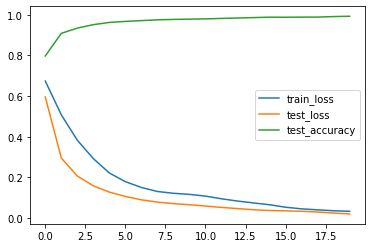

In [ ]:
plt.plot(train_log["first_model"], label="train_loss")
plt.plot(list(map(lambda x: x[0], test_log["first_model"])), label="test_loss")
plt.plot(list(map(lambda x: x[1], test_log["first_model"])), label="test_accuracy")
plt.legend();

### 2. Генерируем и оптимизируем изображение под заданный класс

#### функция для оптимизации изображения под заданный класс

In [ ]:
def optimize_image_by_class(class_number, model, num_steps=50000):
    model.eval()
    
    # создаем тензор, который будем оптимизировать
    image = torch.randn((1, 28, 28))*0.001
    image = image.to(device)
    image.requires_grad = True
    
    # задайте оптимизатор
    # вы можете выбрать какой вам больше нравится
    optim = torch.optim.Adam([image], lr=1e-4)
    
    # задайте лосс функцию соответствующую заданию
    # лосс должен зависесть от class_number
    grads = []
    losses = []
    for i in tqdm(range(num_steps)):
        # здесь в цикле оптимизируется картинка
        # в оптимизатор передается ваш лосс и выход из модели
        # не забывайте обнулять градиенты с optim.zero_grad()
        # также полезно сохранять значения лосс функции и нормы градиента на каждом шаге
        # чтобы было видно как меняются эти значения в процессе "обучения" картинки.
        optim.zero_grad()
        output = model(image.unsqueeze(0))
        loss = F.cross_entropy(output, torch.tensor([class_number]).to(device))
        loss.backward()
        optim.step()
        
        losses.append(loss)
        grads.append(image.grad.norm())
    
    # возвращаете картинку, grads, losses
    return image, grads, losses

In [ ]:
optimized_images = {}
for class_number in range(10):
    model = models["first_model"]
    image, grads, losses = optimize_image_by_class(class_number, model, num_steps=50000)
    optimized_images[class_number] = image

100%|██████████| 50000/50000 [01:28<00:00, 561.80it/s]


#### проверим соответствие классам

In [ ]:
{class_number: (torch.argmax(model(optimized_images[class_number].unsqueeze(0))) == class_number).item() for class_number in optimized_images}

{0: True,
 1: True,
 2: True,
 3: True,
 4: True,
 5: True,
 6: True,
 7: True,
 8: True,
 9: True}

#### визуализируем оптимизированные под класс изображения

In [ ]:
def plot_optimized_images(optimized_images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=120)

    for class_number in range(len(optimized_images)):
        ax = fig.add_subplot(shape[0], shape[1], class_number+1)
        ax.matshow(optimized_images[class_number].squeeze(0).data.cpu().numpy(), cmap = matplotlib.cm.binary)
        plt.title(class_number)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    fig.tight_layout()
    plt.show()

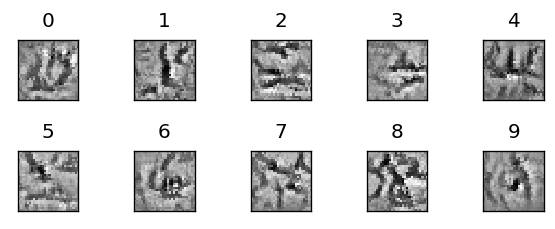

In [ ]:
plot_optimized_images(optimized_images, (2, 5))

**Комментарий:**   
Я бы даже и сказал, что соответствующие цифры, если приглядеться, угадываются )

## <center>**Автокодировщик**

### 1. Реализуем и обучим сверточный автокодировщик

In [71]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)

        self.conv1_activ = None
        self.conv2_activ = None
    
    def forward(self, x):
        x = self.conv1(x)  # 1 28 -> 6 24
        self.conv1_activ = x.clone()
        x = F.relu(x)
        x = self.bn1(x) 
        x = self.conv2(x)  # 6 24 -> 16 20
        self.conv2_activ = x.clone()
        x = F.relu(x)
        x = self.bn2(x)
        x, indices = self.pool(x)  # 20 -> 10
        x = torch.sigmoid(x)
        return x, indices
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.convtrans1 = nn.ConvTranspose2d(16, 6, 5)
        self.bn = nn.BatchNorm2d(16)
        self.convtrans2 = nn.ConvTranspose2d(6, 1, 5)
    
    def forward(self, x):
        x = self.unpool(*x)  # 10 -> 20
        x = F.relu(x)
        x = self.bn(x)        
        x = self.convtrans1(x)  # 16 20 -> 6 24
        x = F.relu(x)
        x = self.convtrans2(x)  # 6 24 -> 1 28
        x = F.relu(x)
        x = torch.tanh(x)
        return x

In [72]:
class ConvAE(nn.Module):
    def __init__(self, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super().__init__()
        self.E = Encoder().to(device)
        self.D = Decoder().to(device)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        h = self.E(x)
        out = self.D(h)
        return out
    
    def encode(self, x):
        with torch.no_grad():
            return self.E(x)
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [73]:
def train(epoch, models, loader, log=None, verbose_num=1):
    train_size = len(loader.sampler)
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(device)
        
        for model in models.values():
            model = model.to(device)
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
    if log is not None:
        for k in models:
            log[k].append(models[k]._loss)   
            
    if epoch == 1 or epoch % verbose_num == 0:
        line = 'Epoch: {} [{}]\n'.format(epoch, train_size)
        losses = '\t' + 'Train set: ' + \
                 ' '.join(['{}: loss: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        report = line + losses
        print(report)

In [74]:
def test(epoch, models, loader, log=None, verbose_num=1):
    test_size = len(loader.sampler)

    test_loss = {mod_label: 0. for mod_label in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            
            output = {mod_label: model(data) for mod_label, model in models.items()}
            for mod_label, model in models.items():
                test_loss[mod_label] += model.loss(output[mod_label], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    if epoch == 1 or epoch % verbose_num == 0:
        avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
        line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
        
        losses = ' '.join([line(k, test_loss[k]) for k in models])
        report = '\t' + 'Test set: ' + losses   
        print(report)

#### Тренируем автокодировщики с 2d латентным слоем

In [75]:
def train_test_models(epochs, models, train_log=None, test_log=None):
    for epoch in np.arange(epochs) + 1:
        for model in models.values():
            model.train()
        train(epoch, models, train_loader, train_log)
        for model in models.values():
            model.eval()
        test(epoch, models, test_loader, test_log)

In [76]:
%%time

ae_models = {'conv_ae': ConvAE()}
train_log = {k: [] for k in ae_models}
test_log = {k: [] for k in ae_models}

train_test_models(50, ae_models, train_log, test_log)

Epoch: 1 [60000]
	Train set: conv_ae: loss: 0.905546
	Test set: conv_ae: loss: 0.9002
Epoch: 2 [60000]
	Train set: conv_ae: loss: 0.862146
	Test set: conv_ae: loss: 0.8603
Epoch: 3 [60000]
	Train set: conv_ae: loss: 0.855627
	Test set: conv_ae: loss: 0.8485
Epoch: 4 [60000]
	Train set: conv_ae: loss: 0.855067
	Test set: conv_ae: loss: 0.8438
Epoch: 5 [60000]
	Train set: conv_ae: loss: 0.845113
	Test set: conv_ae: loss: 0.8412
Epoch: 6 [60000]
	Train set: conv_ae: loss: 0.836987
	Test set: conv_ae: loss: 0.8396
Epoch: 7 [60000]
	Train set: conv_ae: loss: 0.837576
	Test set: conv_ae: loss: 0.8384
Epoch: 8 [60000]
	Train set: conv_ae: loss: 0.838590
	Test set: conv_ae: loss: 0.8376
Epoch: 9 [60000]
	Train set: conv_ae: loss: 0.841275
	Test set: conv_ae: loss: 0.8369
Epoch: 10 [60000]
	Train set: conv_ae: loss: 0.837349
	Test set: conv_ae: loss: 0.8364
Epoch: 11 [60000]
	Train set: conv_ae: loss: 0.832934
	Test set: conv_ae: loss: 0.8360
Epoch: 12 [60000]
	Train set: conv_ae: loss: 0.83529

#### посмотрим на кривые обучения

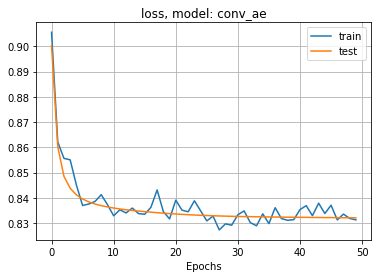

In [77]:
for model in ae_models:
    plt.plot(train_log[model], label="train")
    plt.plot(test_log[model], label="test")
    plt.title(f"loss, model: {model}")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()

### Оптимизируем изображения по заданному условию.
Будем оптимизировать на максимум средней суммы квадратов карты активации на сверточных нейронах

#### функция для оптимизации изображения под активацию сверточных нейронов автокодировщика

In [87]:
def optimize_image_by_convactivation(model, conv_act_target="1", num_steps=50000):
    normalize = transforms.Normalize((0.5,), (0.5,))
    model.eval()
    
    # создаем тензор, который будем оптимизировать
    image = torch.sigmoid(torch.randn((1, 28, 28))*0.001)
    image = image.to(device)
    image.requires_grad = True

    # подготавливаем вход
    # image_processed = normalize(torch.sigmoid(torch.randn((1, 28, 28))))

    # задайте оптимизатор
    # вы можете выбрать какой вам больше нравится
    optim = torch.optim.Adam([image], lr=1e-4)
    
    # задайте лосс функцию соответствующую заданию
    # лосс должен зависесть от class_number
    grads = []
    losses = []
    for i in tqdm(range(num_steps)):
        # здесь в цикле оптимизируется картинка
        # в оптимизатор передается ваш лосс и выход из модели
        # не забывайте обнулять градиенты с optim.zero_grad()
        # также полезно сохранять значения лосс функции и нормы градиента на каждом шаге
        # чтобы было видно как меняются эти значения в процессе "обучения" картинки.
        optim.zero_grad()
        output = model((normalize(image).unsqueeze(0)))
        if conv_act_target == "1":
            conv_activ = model.E.conv1_activ
        elif conv_act_target == "2":
            conv_activ = model.E.conv2_activ
        else:
            raise ValueError("conv_act_target is wrong")
#         loss = F.cross_entropy(output, torch.tensor([class_number]))
        loss = - (conv_activ**2).mean()
        loss.backward()
        optim.step()
        
        losses.append(loss)
        grads.append(image.grad.norm())
    
    # возвращаете картинку, grads, losses
    image_out = torch.sigmoid(image)
    return image_out, grads, losses

### **conv1**

In [92]:
image, grads, losses = optimize_image_by_convactivation(ae_models["conv_ae"], conv_act_target="1", num_steps=50000)

100%|██████████| 50000/50000 [02:35<00:00, 322.19it/s]


#### сгенерированное и оптимизированное изображение

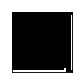

In [93]:
to_plot = image.unsqueeze(0).data.cpu().numpy()

plot_mnist(to_plot, (1, 1))

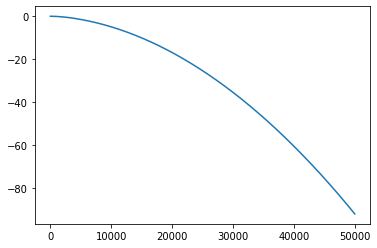

In [94]:
plt.plot(losses);

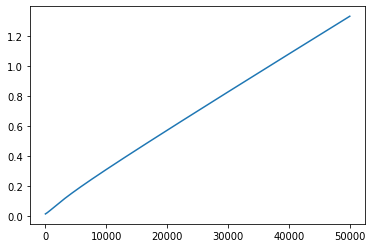

In [95]:
plt.plot(grads);

### **conv2**

In [96]:
image, grads, losses = optimize_image_by_convactivation(ae_models["conv_ae"], conv_act_target="2", num_steps=50000)

100%|██████████| 50000/50000 [02:53<00:00, 288.02it/s]


#### сгенерированное и оптимизированное изображение

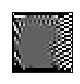

In [97]:
to_plot = image.unsqueeze(0).data.cpu().numpy()

plot_mnist(to_plot, (1, 1))

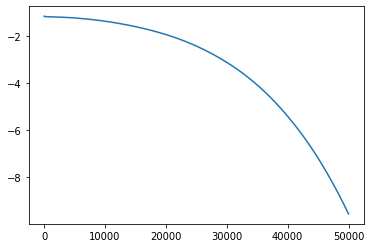

In [98]:
plt.plot(losses);

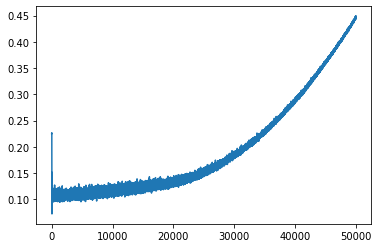

In [99]:
plt.plot(grads);

**Комментарий:**   
Оптимизация производилась 2 раза, по активации на 2х разных сверточных слоях. В первом случае картинка получилась довольно "скучной", зато во втором случае рисунок стал явно по-интереснее. Во втором случае сверточный слой был **более глубокий**. 